In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
#reading csv file to check data
df=pd.read_csv('flower/flower_label.csv')
df.head(8)

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0
5,0006.png,1
6,0007.png,6
7,0008.png,0


In [3]:
#N_CLASSES = df['label'].nunique()
N_CLASSES = df.label.nunique()

N_CLASSES

10

<Axes: xlabel='label'>

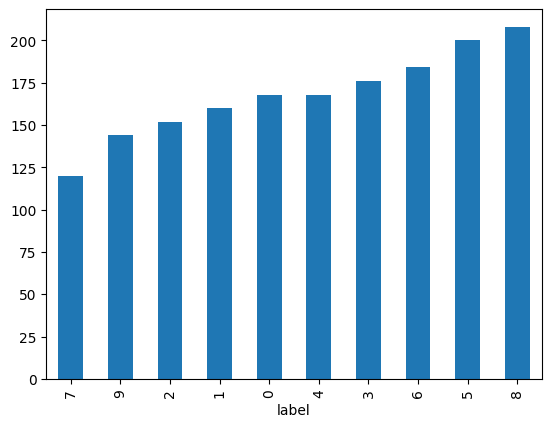

In [25]:
df['label'].value_counts().sort_values().plot.bar()

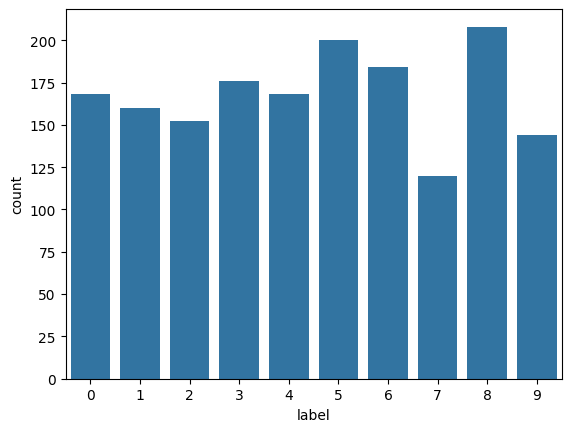

In [18]:
sns.countplot(data=df,x=df['label'])
plt.show()

In [5]:
# Preprocecss data if it has no image extension
df["file_png"] = df["file"].apply(lambda x: 'path/'+x + ".png")
#df.head()

In [6]:
#delecting label == 1
#choosing data exept one label
#df2=df[df.label != 1]
#df2.head(8)

In [27]:
df['label'] = df['label'].astype('str')

In [28]:
df.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [29]:
BATCH_SIZE=32
HEIGHT, WIDTH = 224,224

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=30,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                validation_split = 0.1)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split = 0.1)

In [31]:
train_dir='flower/flower_imgs/'
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory= train_dir,
    x_col="file",
    y_col="label",
    class_mode="categorical", #categorical , binary 
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode='rgb', #"rgb", "rgba", or "grayscale"
    target_size=(HEIGHT, WIDTH),
    subset='training',
    seed=0,)

Found 756 validated image filenames belonging to 10 classes.


C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 840 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


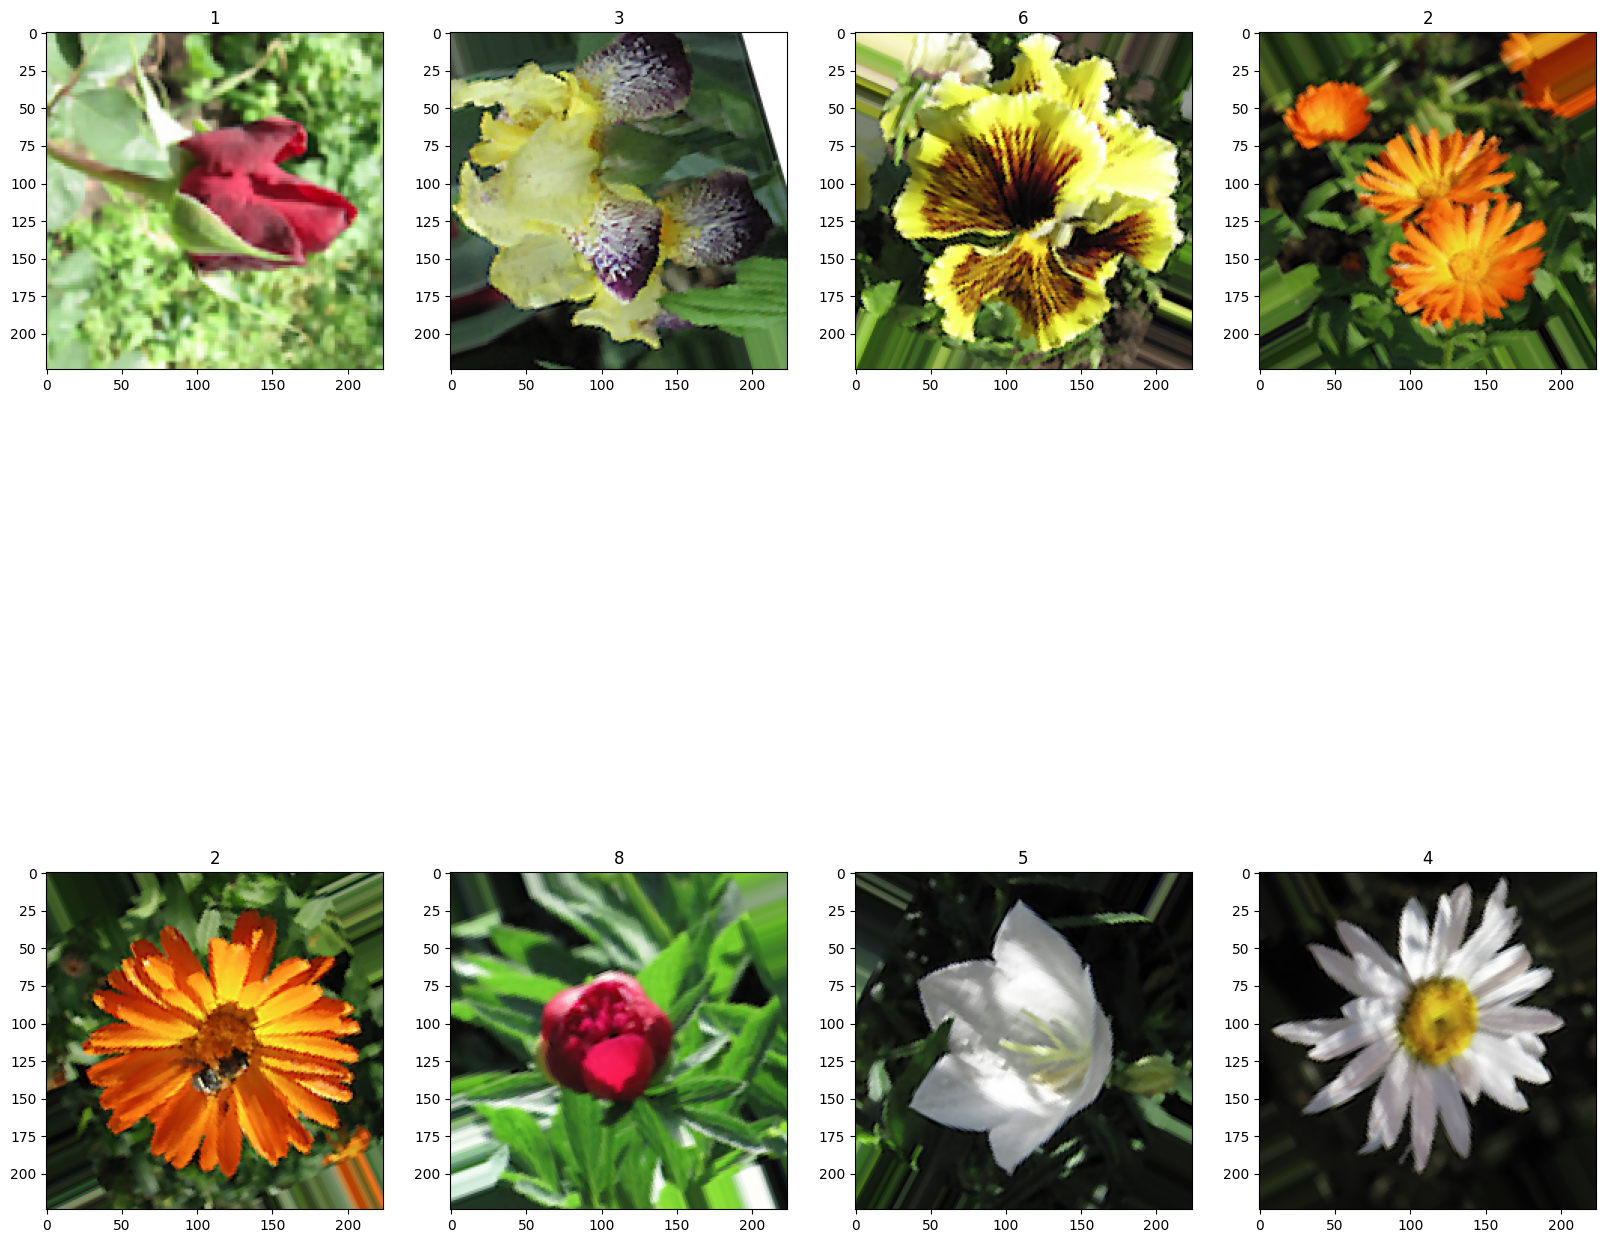

In [32]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [33]:
valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col="file",
    y_col="label",
    class_mode="categorical", 
    shuffle=False,
    batch_size=BATCH_SIZE, 
    color_mode='rgb', #grayscale
    target_size=(HEIGHT, WIDTH),
    validate_filenames=0.1,
    subset='validation',
    seed=0)


Found 84 validated image filenames belonging to 10 classes.


C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 840 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


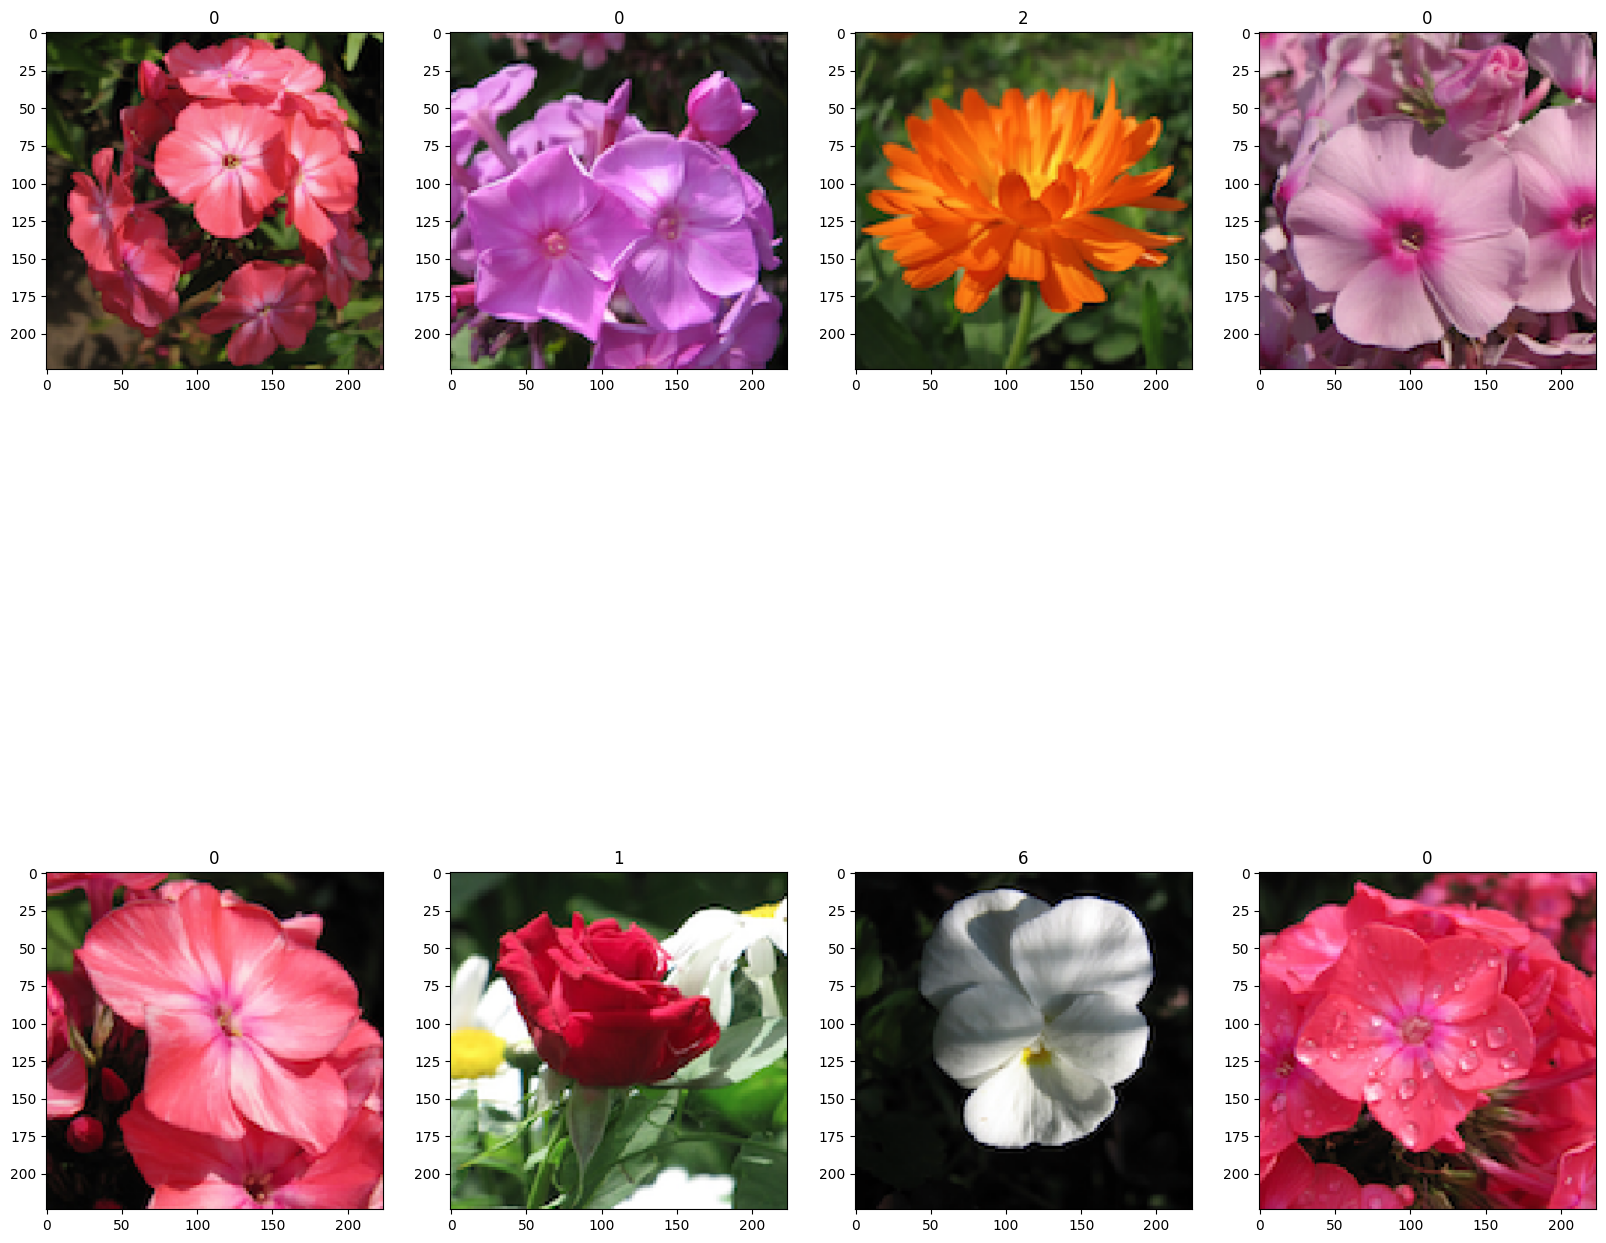

In [34]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [35]:
from tensorflow import keras
# Creating the model using the Sequential API
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv1", input_shape= (224,224,3)))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool1"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv2"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool2"))
model.add(keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, 
                padding="same", activation=keras.layers.LeakyReLU(alpha=0.02), name="Conv3"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool3"))

model.add(keras.layers.Flatten(name="Flatten1"))
model.add(keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.02), name="Dense1"))
model.add(keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.02), name="Dense2"))
model.add(keras.layers.Dense(10, activation="softmax", name="Output"))

# The model’s summary() method displays all the model’s layers
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 224, 224, 64)      9472      
                                                                 
 Pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 112, 112, 128)     204928    
                                                                 
 Pool2 (MaxPooling2D)        (None, 56, 56, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 56, 56, 256)       295168    
                                                                 
 Pool3 (MaxPooling2D)        (None, 28, 28, 256)       0         
                                                                 
 Flatten1 (Flatten)          (None, 200704)            0

In [36]:
# Compiling the model
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer= optimizer, metrics=["accuracy"])

# Learning rate scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.00001, patience=5,
                                      monitor="val_accuracy", min_lr=0.0000001)

# Interrupts training when it measures no progress on the validation set
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, monitor = "val_loss",
                                                  restore_best_weights=True)

In [37]:
# Training the model
history = model.fit(train_generator,
                    steps_per_epoch = len(train_generator) ,
                    epochs          = 10,  
                    validation_data = valid_generator, 
                    validation_steps=len(valid_generator),
                    callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/10
24/24 [==============================] - 20s 508ms/step - loss: 2.2693 - accuracy: 0.2341 - val_loss: 1.8537 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 2/10
24/24 [==============================] - 7s 284ms/step - loss: 1.4220 - accuracy: 0.4815 - val_loss: 1.5190 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
24/24 [==============================] - 7s 280ms/step - loss: 1.1607 - accuracy: 0.5979 - val_loss: 1.0118 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 4/10
24/24 [==============================] - 7s 286ms/step - loss: 0.9414 - accuracy: 0.6746 - val_loss: 0.9879 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 5/10
24/24 [==============================] - 7s 289ms/step - loss: 0.8618 - accuracy: 0.6971 - val_loss: 0.8683 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 6/10
24/24 [==============================] - 8s 319ms/step - loss: 0.7819 - accuracy: 0.7103 - val_loss: 0.8972 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 7/10
24/24 [==============================] - 7s 302ms/step - l

In [38]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

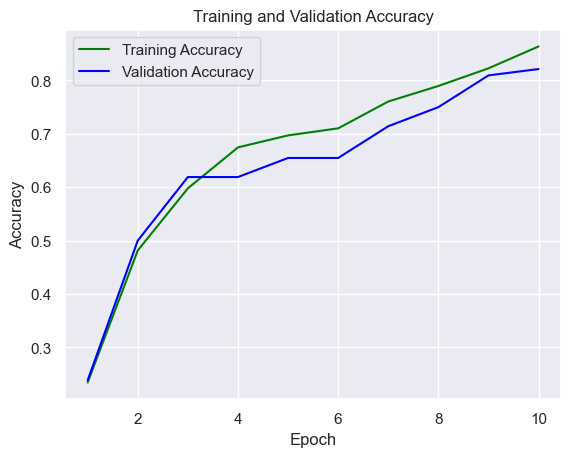

In [39]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

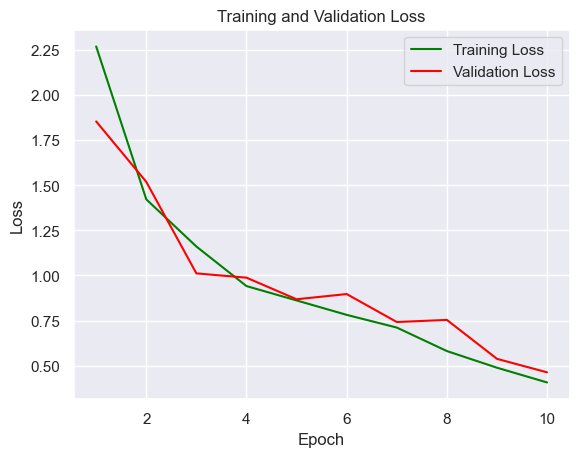

In [40]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

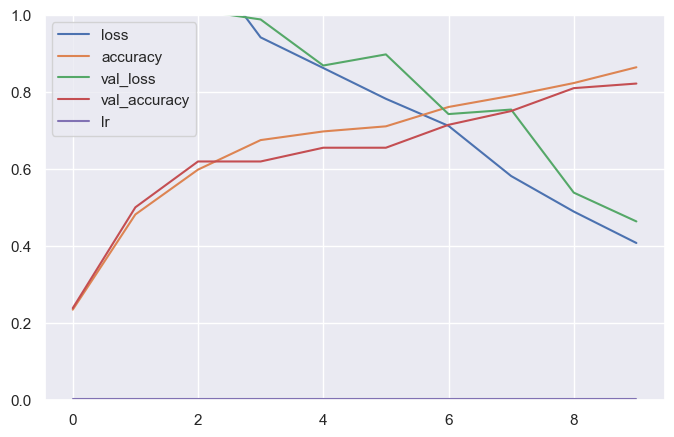

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [42]:
predictions = model.predict(valid_generator)

3/3 [==============================] - 0s 54ms/step


In [43]:
from sklearn.metrics import classification_report
print(classification_report(valid_generator.classes, predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.78      0.88      0.82         8
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89        10
           4       1.00      1.00      1.00         6
           5       0.50      1.00      0.67         7
           6       1.00      0.75      0.86        12
           7       1.00      1.00      1.00         8
           8       0.80      0.57      0.67         7
           9       0.83      0.83      0.83         6

    accuracy                           0.82        84
   macro avg       0.86      0.85      0.84        84
weighted avg       0.86      0.82      0.83        84



<Axes: >

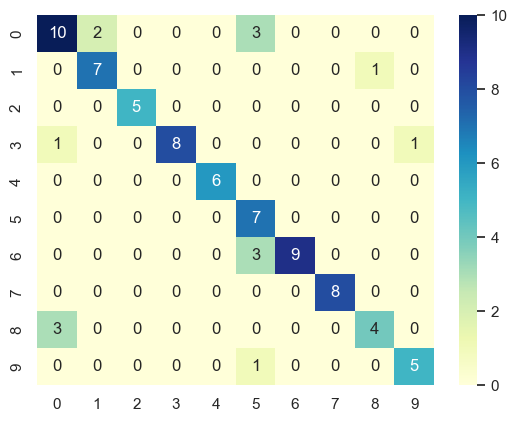

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_generator.classes, predictions.argmax(axis=-1))

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [68]:
model.save('flower.h5')

In [71]:
img = cv2.imread("0262.png")
H,W,C = 224,224,3
img = cv2.resize(img, (H, W)) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = img.astype("float32")  
img = img / 255.0

img = img.reshape(1,H,W,C)
print(img.shape)

prediction = np.argmax(model.predict(img),axis=-1)
print(prediction)


(1, 224, 224, 3)
1/1 [==============================] - 0s 21ms/step
[4]


In [61]:
model.predict(img)

1/1 [==============================] - 0s 22ms/step


array([[5.4536825e-03, 9.9450928e-01, 1.1396040e-11, 4.4110928e-14,
        1.9677412e-15, 5.4560365e-15, 2.4536047e-07, 5.9510133e-13,
        8.1767314e-07, 3.6012105e-05]], dtype=float32)

In [2]:
# https://gradio.app/docs/

import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import requests
import cv2

model=tf.keras.models.load_model('flower.h5')

def inference(img):
    labels =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    H,W,C = 224,224,3
    img = cv2.resize(img, (H, W)) 
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float32") / 255.0 ).reshape(1,H,W,C)
    pred = model.predict(img).flatten()
    print(pred)
    prediction = [pred[0], pred[1], pred[2], pred[3], pred[4], pred[5], pred[6], pred[7], pred[8], pred[9]]
    dictionary = dict(zip(labels, map(float, prediction)))
    return dictionary

nbr_top_classes = 10
gr.Interface(fn=inference, 
             inputs=gr.Image(), 
             outputs=gr.Label(num_top_classes=nbr_top_classes),
             theme="dark"
             ).launch(share=True) #, debug=True Use in Colab


C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\gradio\blocks.py:555: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-65eef1f6-71b300497a277007395ec3e4;92000add-7b92-4727-a26b-154da9c6911c)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running on local URL:  http://127.0.0.1:7864
1/1 [==============================] - 0s 114ms/step
[2.5276102e-03 1.1083051e-02 1.6720450e-10 1.6611638e-02 9.5848307e-09
 6.2798595e-01 1.4238891e-02 1.0431092e-02 5.2572240e-04 3.1659603e-01]


ERROR:    Exception in ASGI application
  + Exception Group Traceback (most recent call last):
  |   File "C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\starlette\middleware\base.py", line 192, in __call__
  |     await response(scope, wrapped_receive, send)
  |   File "C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\starlette\responses.py", line 257, in __call__
  |     async with anyio.create_task_group() as task_group:
  |   File "C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\anyio\_backends\_asyncio.py", line 678, in __aexit__
  |     raise BaseExceptionGroup(
  | exceptiongroup.ExceptionGroup: unhandled errors in a TaskGroup (1 sub-exception)
  +-+---------------- 1 ----------------
    | Traceback (most recent call last):
    |   File "C:\Users\Nvidia\anaconda3\envs\py310\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 412, in run_asgi
    |     result = await app(  # type: ignore[func-returns-value]
    |   File "C:\Users\Nvidia\anaconda3\env

1/1 [==============================] - 0s 24ms/step
[2.3814315e-02 1.7590537e-05 2.4411133e-08 2.1448504e-05 2.1042179e-03
 8.7005407e-01 1.0264230e-01 1.1167580e-08 8.9036266e-04 4.5554427e-04]

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/03/11 13:59:09 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


1/1 [==============================] - 0s 33ms/step
[2.9455000e-04 2.9084061e-17 7.5012276e-22 9.9969709e-01 1.6633614e-12
 3.1911682e-08 8.2852775e-06 8.9814040e-19 8.5827345e-10 1.9462465e-09]
